In [42]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний

In [2]:
#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
import numpy as np
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

In [3]:
#коннект к базе данных

connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [4]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    countIf(action = 'like')/countIf(action = 'view') CTR
FROM 
    simulator_20240620.feed_actions
WHERE hour_time >= toDateTime('2024-06-01 00:00:00') AND 
    hour_time <= toDateTime('2024-07-01 00:00:00')
GROUP BY hour_time
ORDER BY 
    hour_time
'''

In [5]:
activity = ph.read_clickhouse(query=query, connection=connection)
activity.head()

,hour_time,CTR
0,2024-06-01 00:00:00,0.225492
1,2024-06-01 01:00:00,0.210429
2,2024-06-01 02:00:00,0.216842
3,2024-06-01 03:00:00,0.208710
4,2024-06-01 04:00:00,0.209122


In [6]:
#зададим рисовательный шаблон для сиборна
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

<Axes: xlabel='hour_time', ylabel='CTR'>

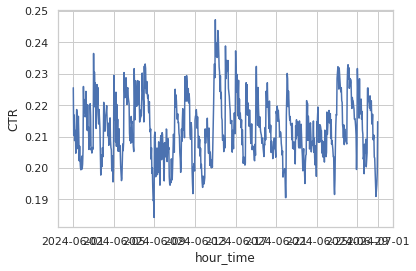

In [7]:
#как менялся CTR
sns.lineplot(x="hour_time", y="CTR", data=activity)

In [8]:
#эксплораторные штуки
from orbit.eda import eda_plot

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

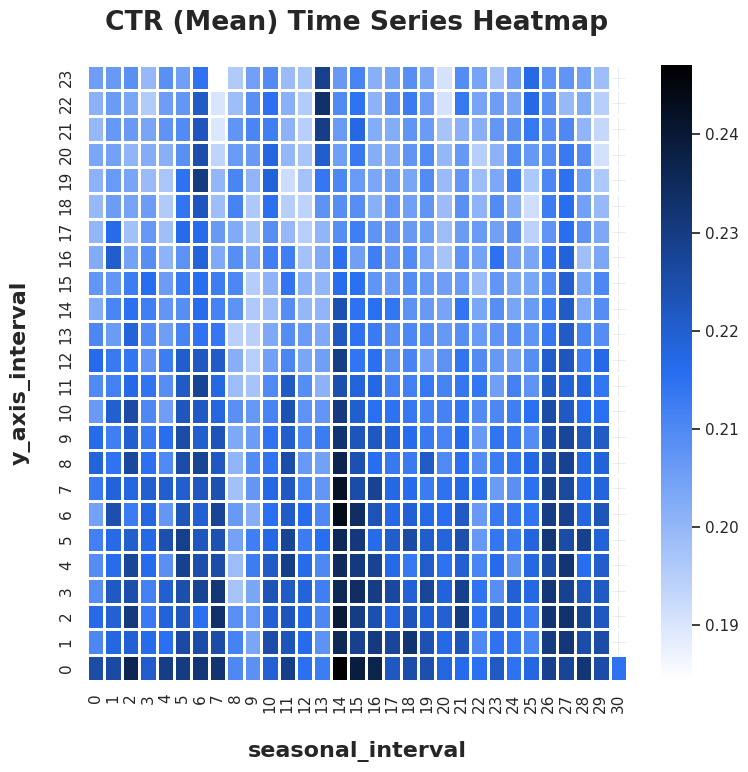

In [9]:
#тепловая карта
_ = eda_plot.ts_heatmap(df=activity, date_col="hour_time", value_col="CTR", seasonal_interval=24, normalization=False)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

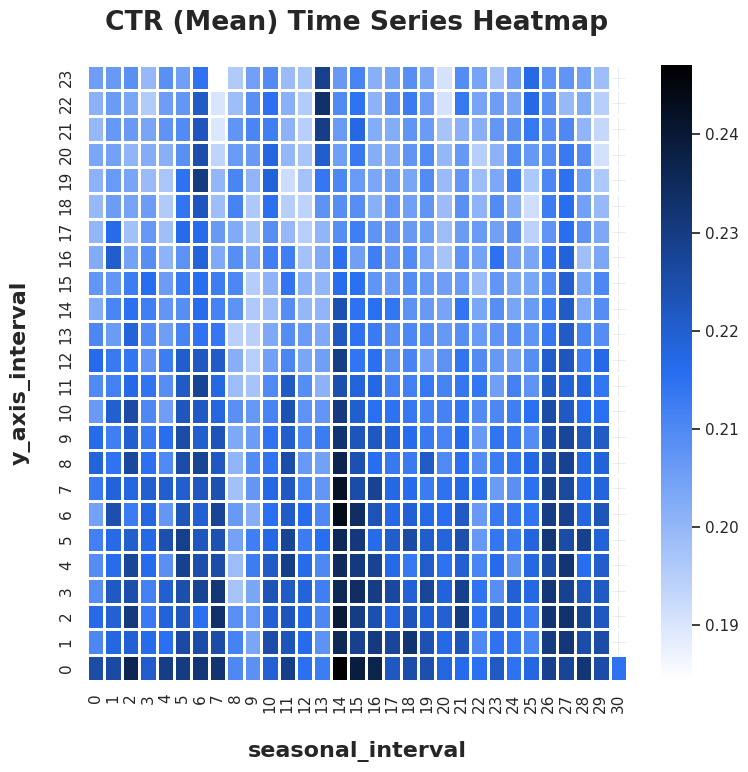

In [10]:
_ = eda_plot.ts_heatmap(df=activity, date_col='hour_time', value_col='CTR', seasonal_interval=24, normalization=False)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

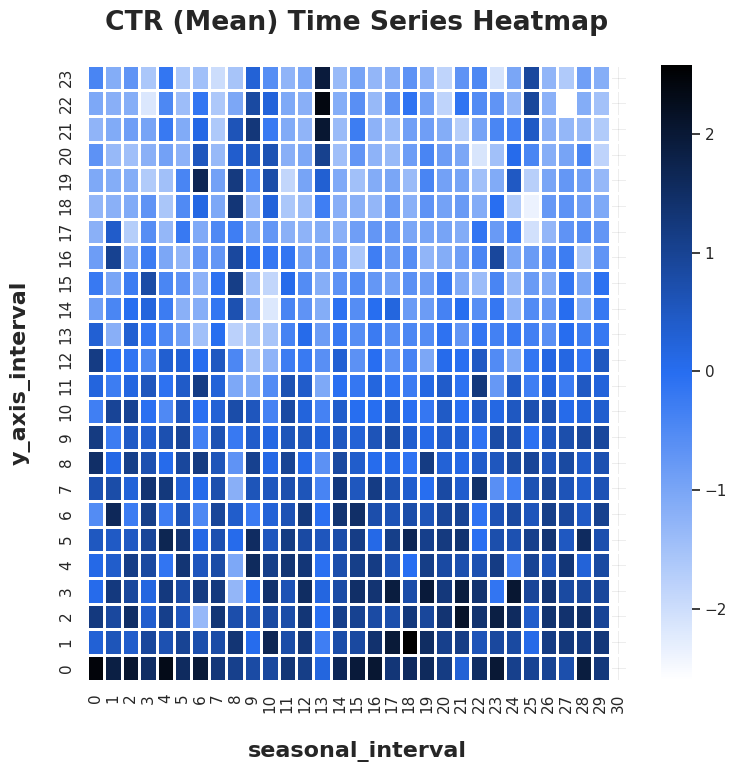

In [11]:
_ = eda_plot.ts_heatmap(df=activity, date_col="hour_time", value_col="CTR", seasonal_interval=24, normalization=True)

In [12]:
dlt = DLT(response_col="CTR", #название колонки с метрикой
          date_col="hour_time", #название колонки с датами-временем
          seasonality=24, #длина периода сезонности
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

2024-08-20 04:43:21 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [13]:
dlt = DLT(response_col='CTR',
          date_col='hour_time',
          seasonality=24,
          estimator='stan-map',
          n_bootstrap_draws=1000)

2024-08-20 04:43:21 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [14]:
dlt.fit(activity)

2024-08-20 04:43:21 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


In [15]:
future_df = dlt.make_future_df(periods=24*7)
future_df.head()

,hour_time
0,2024-07-01 01:00:00
1,2024-07-01 02:00:00
2,2024-07-01 03:00:00
3,2024-07-01 04:00:00
4,2024-07-01 05:00:00


In [16]:
predicted_df = dlt.predict(df=future_df)
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95
0,2024-07-01 01:00:00,0.202815,0.210816,0.218070
1,2024-07-01 02:00:00,0.202458,0.211273,0.220184
2,2024-07-01 03:00:00,0.201905,0.211154,0.220739
3,2024-07-01 04:00:00,0.199052,0.209032,0.219208
4,2024-07-01 05:00:00,0.199550,0.210182,0.221087


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

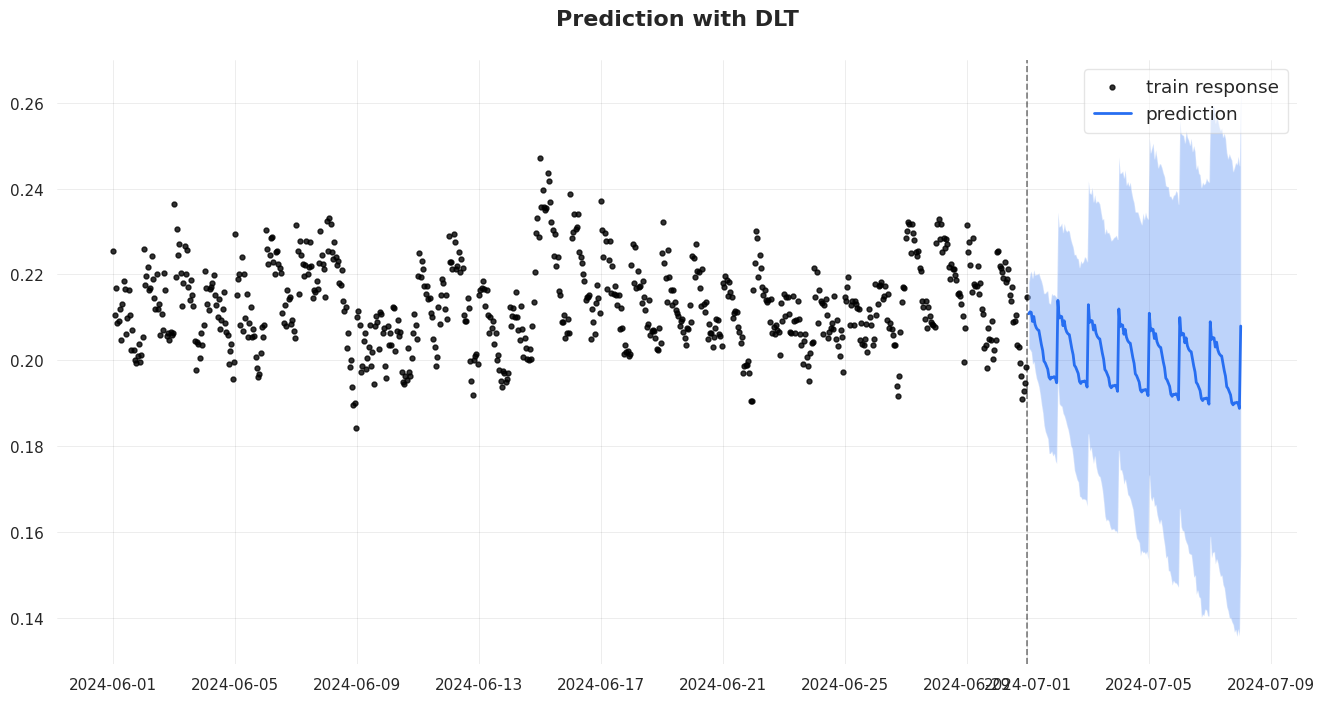

In [17]:
_ = plot_predicted_data(activity, predicted_df, 'hour_time', 'CTR', title='Prediction with DLT')

In [18]:
predicted_df = dlt.predict(df=future_df, decompose=True)
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2024-07-01 01:00:00,0.203430,0.210816,0.217321,0.196155,0.203542,0.210046,0.007275,0.007275,0.007275,0.0,0.0,0.0
1,2024-07-01 02:00:00,0.202409,0.211273,0.219235,0.194636,0.203500,0.211461,0.007773,0.007773,0.007773,0.0,0.0,0.0
2,2024-07-01 03:00:00,0.201195,0.211154,0.220165,0.193500,0.203459,0.212470,0.007696,0.007696,0.007696,0.0,0.0,0.0
3,2024-07-01 04:00:00,0.198014,0.209032,0.219373,0.192399,0.203417,0.213758,0.005615,0.005615,0.005615,0.0,0.0,0.0
4,2024-07-01 05:00:00,0.198441,0.210182,0.221121,0.191635,0.203376,0.214314,0.006806,0.006806,0.006806,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

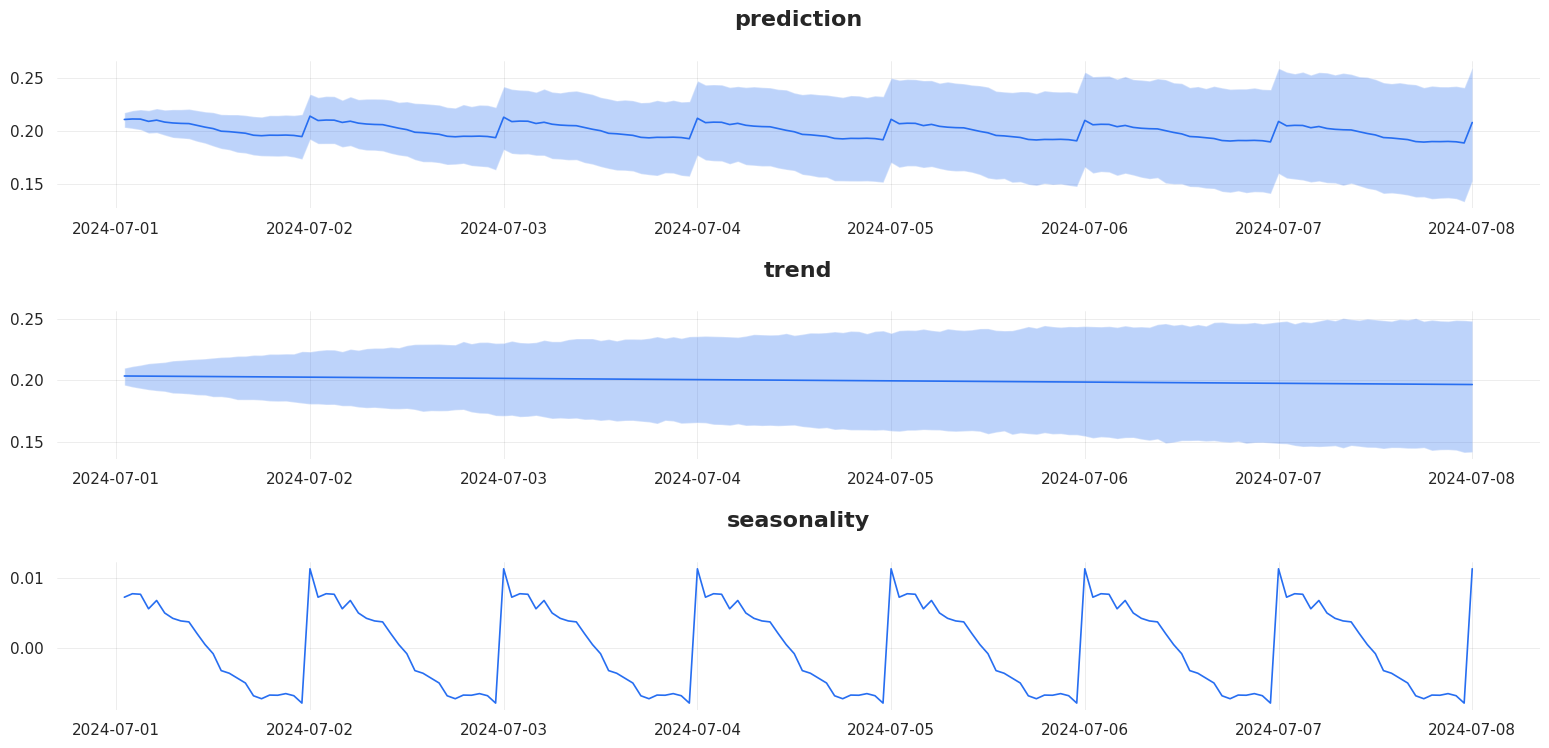

In [19]:
_ = plot_predicted_components(predicted_df, 'hour_time', plot_components=['prediction', 'trend', 'seasonality'])

In [20]:
dlt_mcmc = DLT(seasonality=24, response_col = 'CTR', date_col = 'hour_time', 
               estimator='stan-mcmc',
               num_warmup=2000,
               num_sample=1000)



In [21]:
dlt_mcmc.fit(activity)

2024-08-20 04:43:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

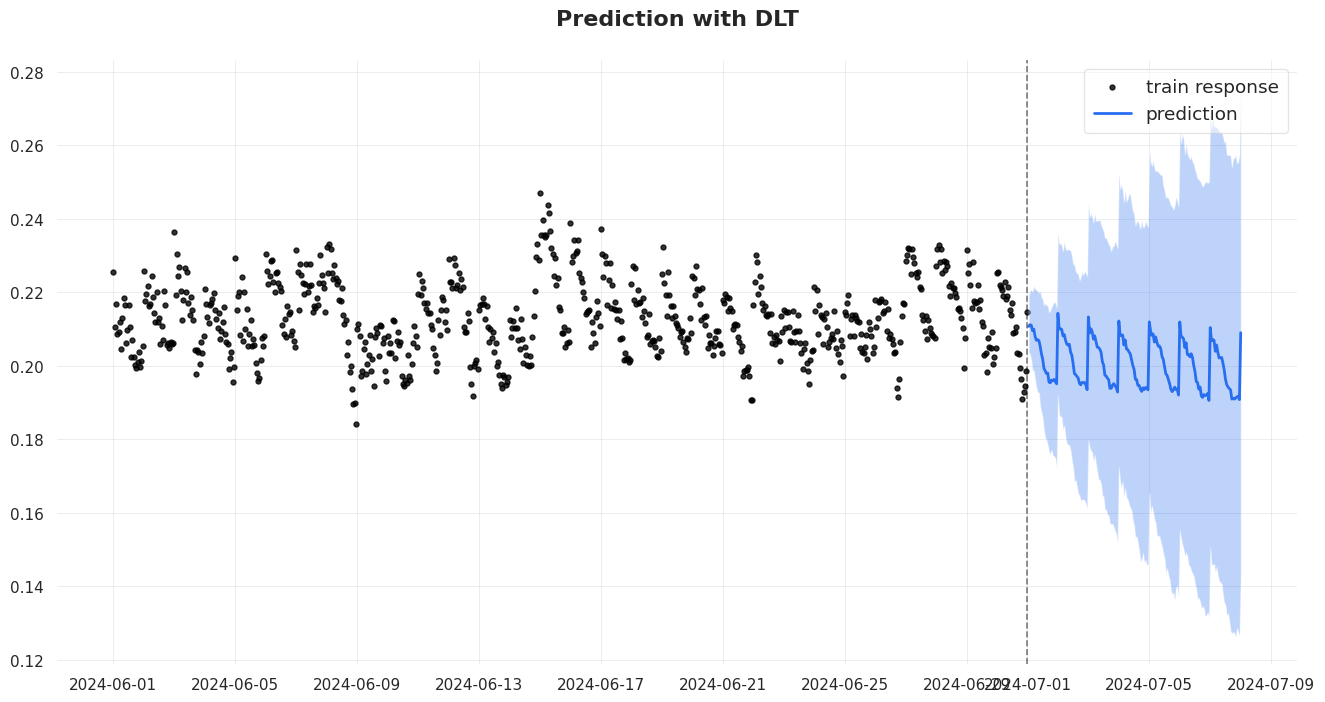

In [22]:
future_df = dlt_mcmc.make_future_df(periods=24*7)

predicted_df = dlt_mcmc.predict(df=future_df)

_ = plot_predicted_data(activity, predicted_df, "hour_time", 'CTR', title='Prediction with DLT')

In [23]:
predicted_df = dlt_mcmc.predict(df=future_df, decompose=True)

predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2024-07-01 01:00:00,0.203008,0.210946,0.219071,0.195314,0.203183,0.211250,0.006344,0.007791,0.009177,0.0,0.0,0.0
1,2024-07-01 02:00:00,0.202709,0.211379,0.219839,0.194597,0.203336,0.211735,0.006832,0.008032,0.009300,0.0,0.0,0.0
2,2024-07-01 03:00:00,0.200959,0.210630,0.220210,0.193466,0.202869,0.212432,0.006392,0.007708,0.008844,0.0,0.0,0.0
3,2024-07-01 04:00:00,0.197135,0.208676,0.219314,0.191696,0.203054,0.213558,0.004304,0.005562,0.006799,0.0,0.0,0.0
4,2024-07-01 05:00:00,0.198214,0.209869,0.222229,0.191278,0.203122,0.215278,0.005619,0.006828,0.008066,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

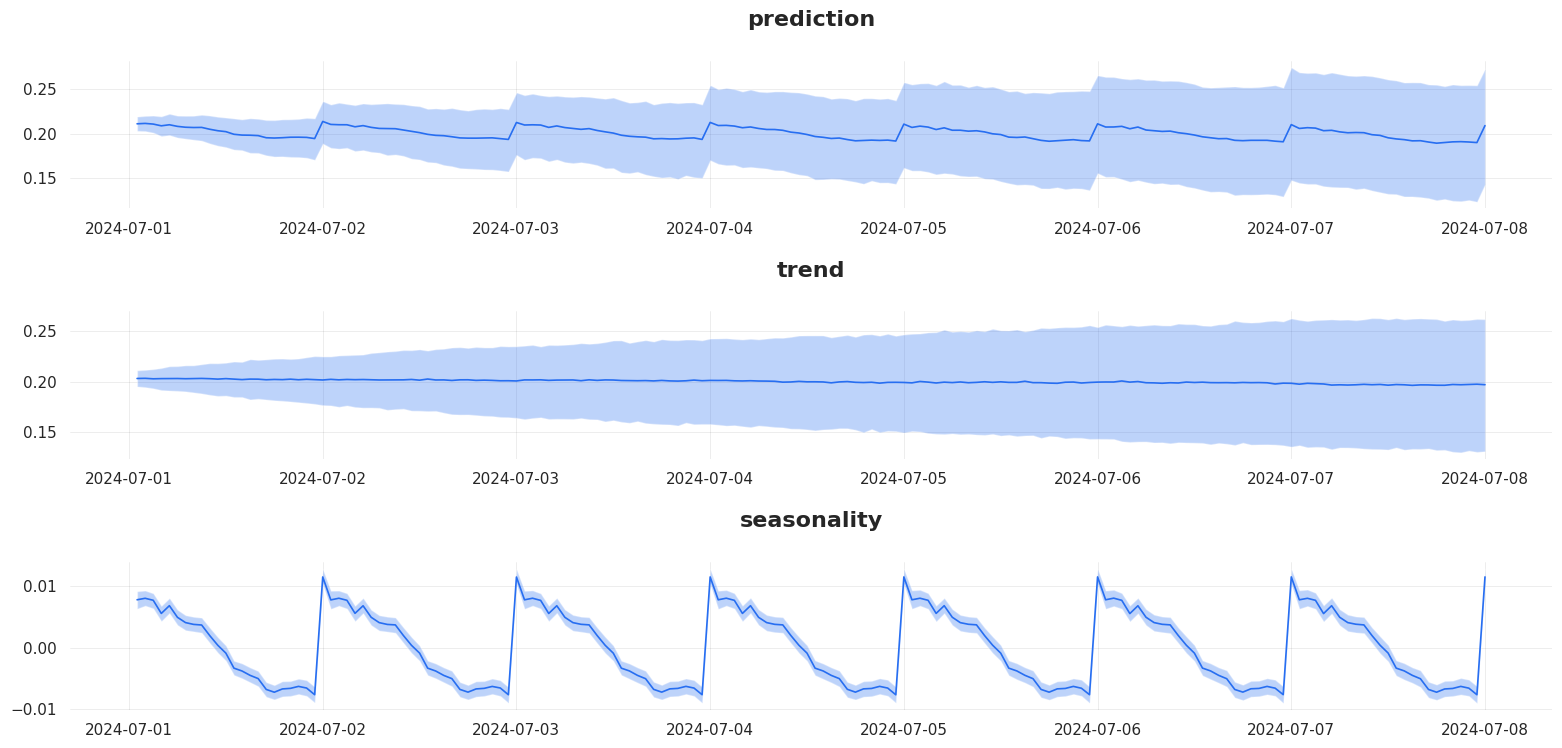

In [24]:
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

In [25]:
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров

In [26]:
#expanding
bt_exp = BackTester(
    model=dlt,
    df=activity,
    min_train_len=24*7,
    incremental_len=24,
    forecast_len=24,
    window_type='expanding'
)

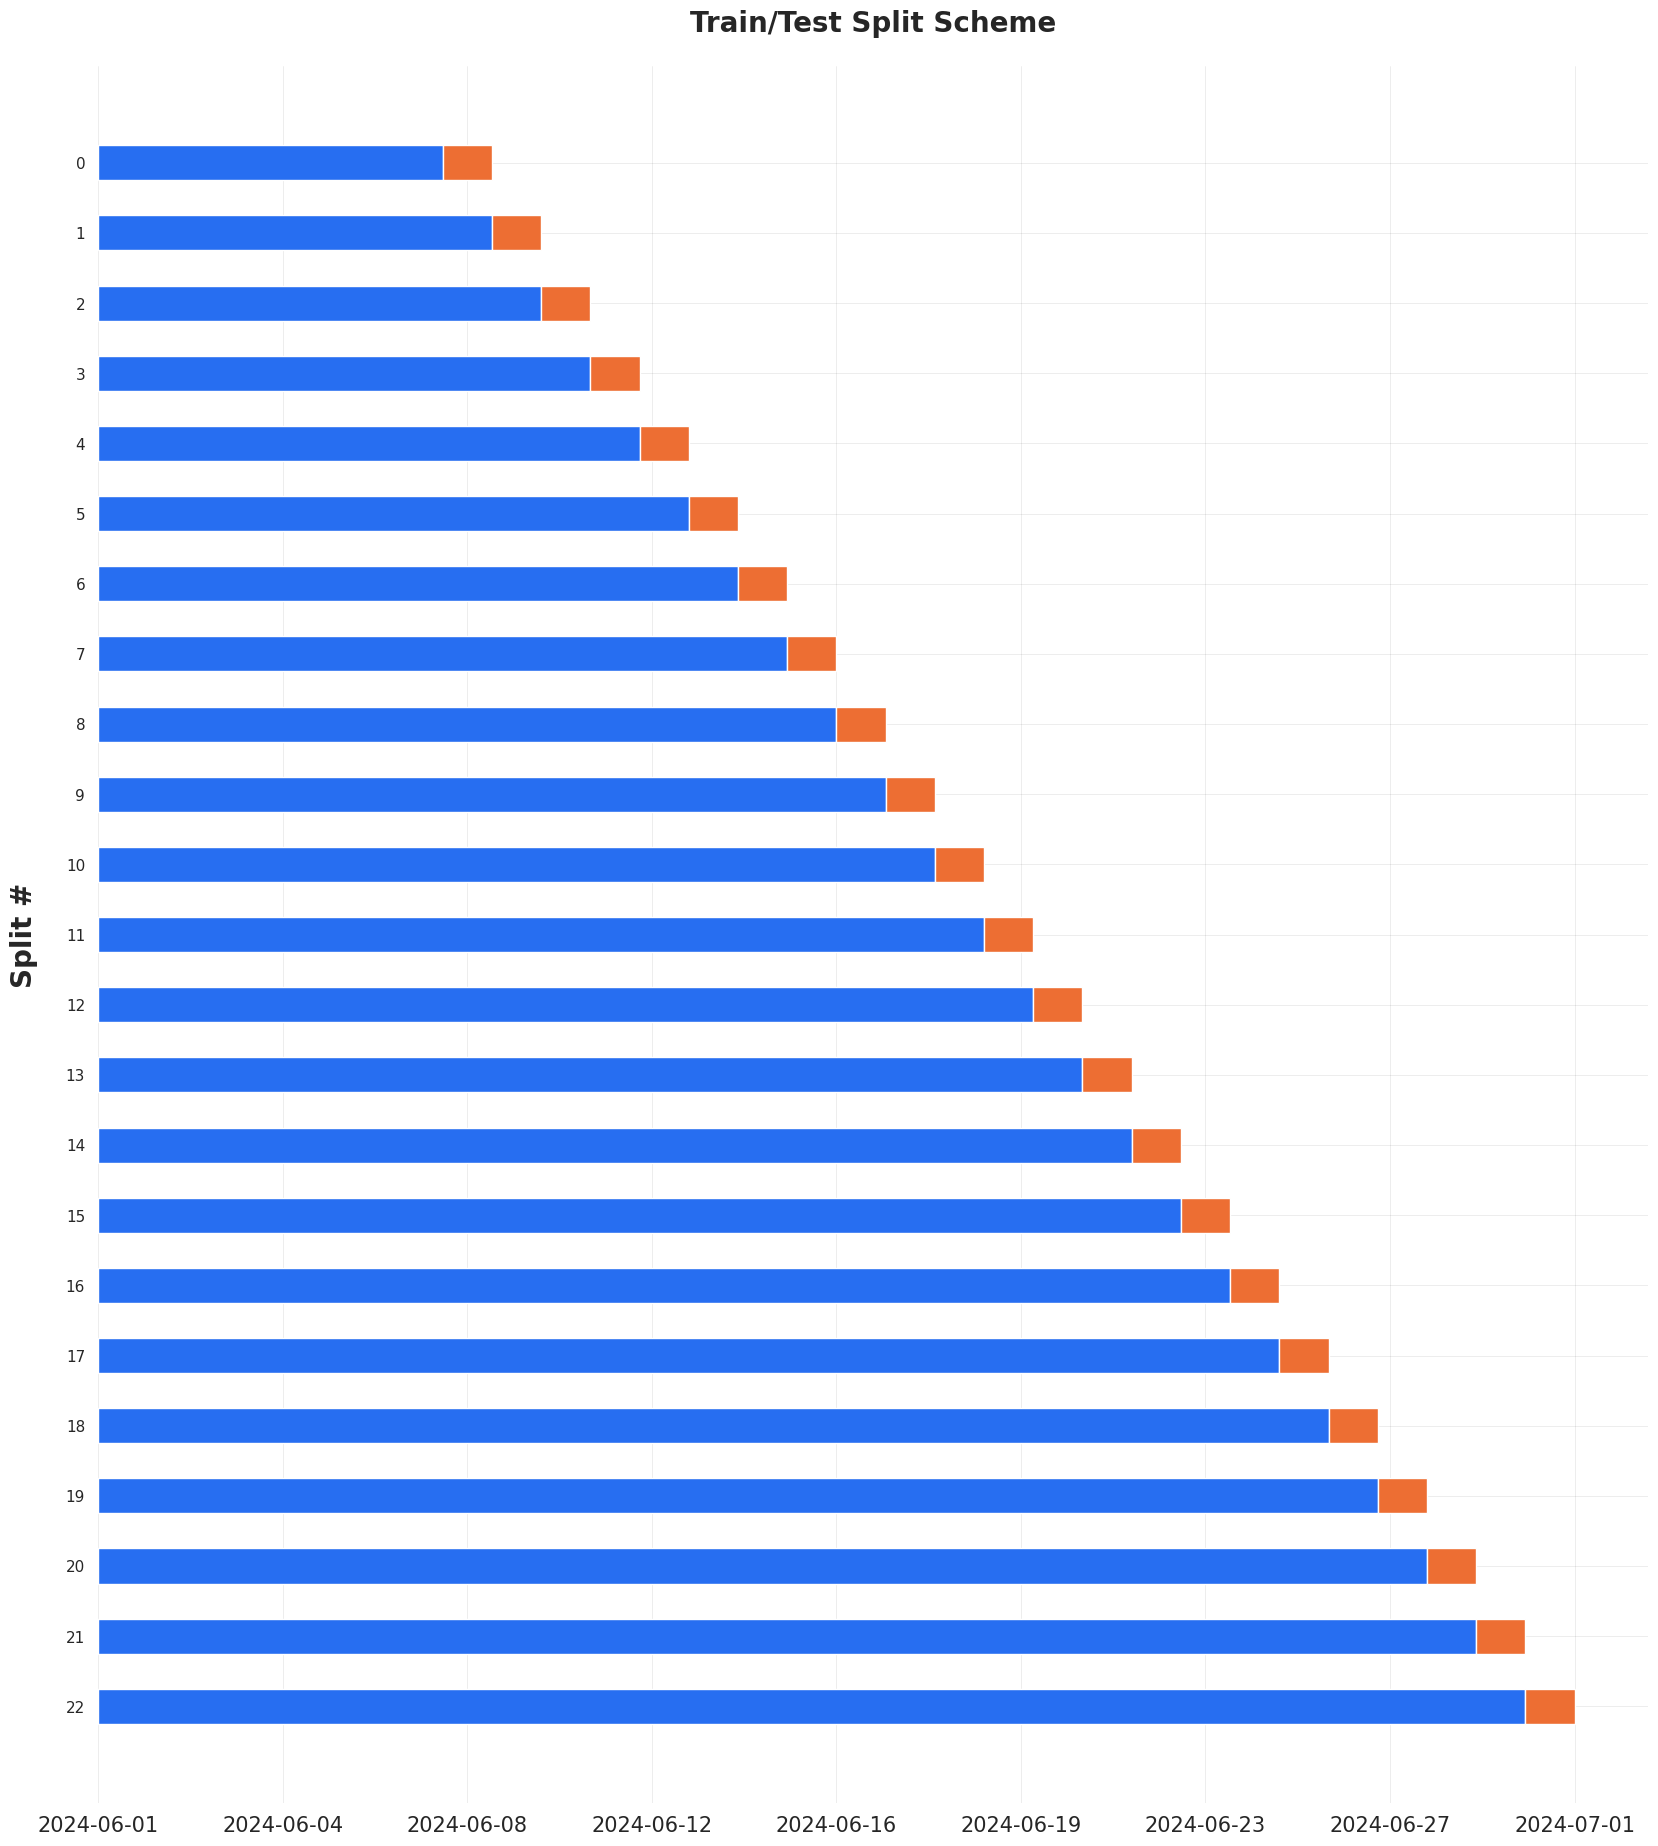

In [27]:
bt_exp.plot_scheme()

In [28]:
#rolling

bt_roll = BackTester(
    model=dlt,
    df=activity,
    min_train_len=24*7,
    incremental_len=24,
    forecast_len=24,
    window_type="rolling",
)

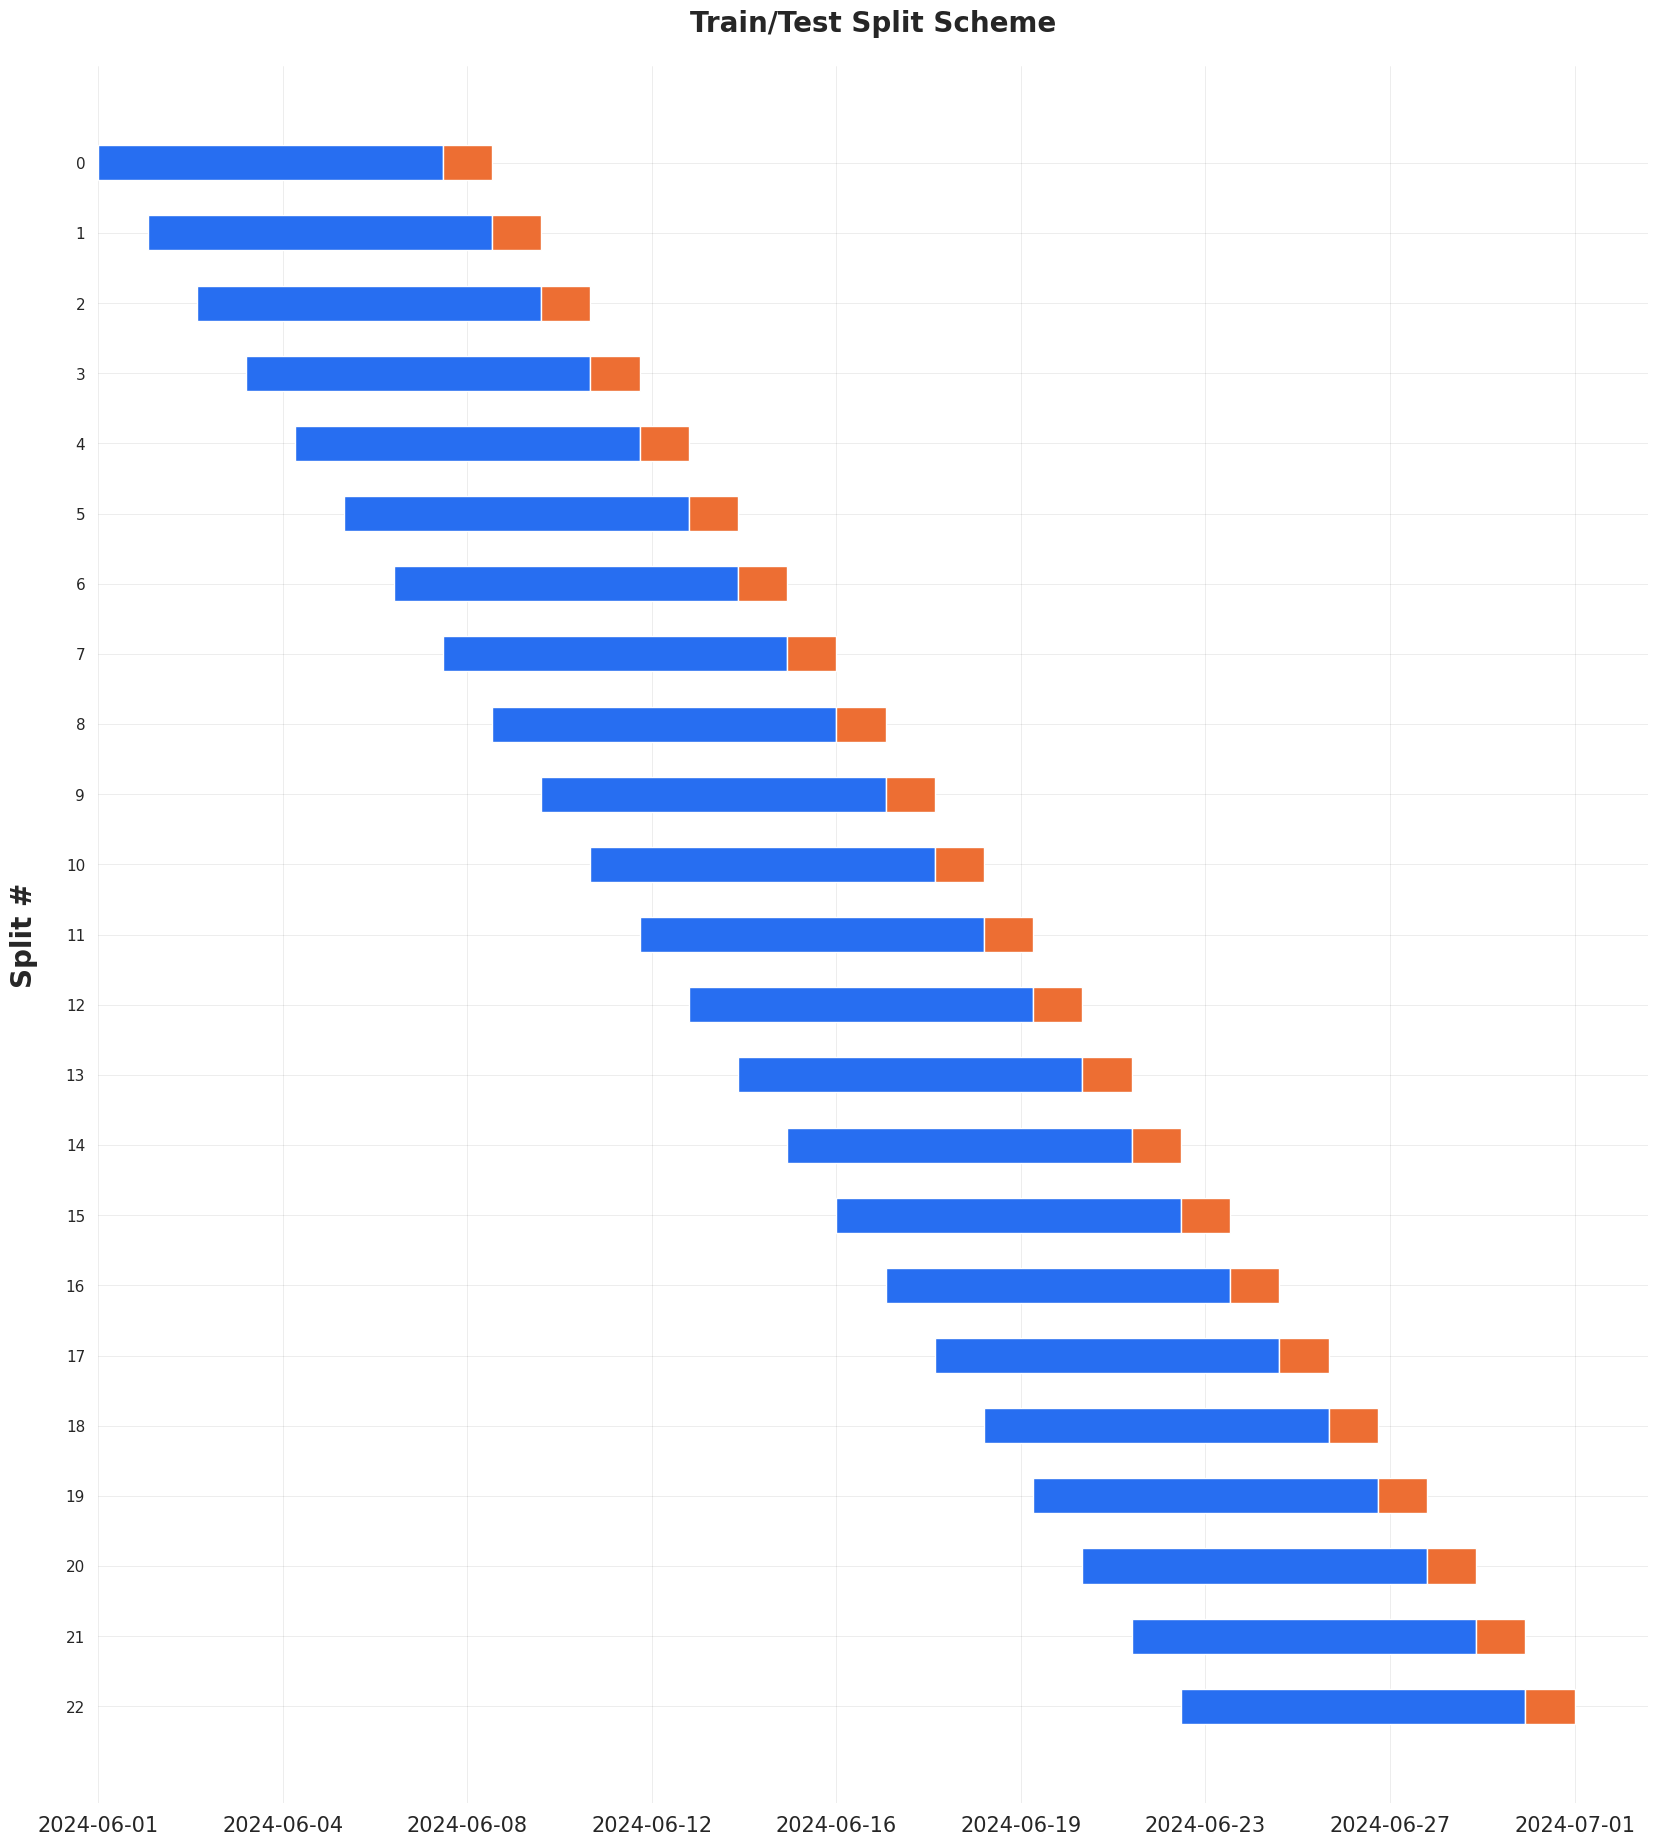

In [29]:
bt_roll.plot_scheme()

In [30]:
bt_exp.fit_predict() #обучаем
bt_exp.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,0.031810,False
1,wmape,0.031693,False
2,mape,0.031942,False
3,mse,0.000084,False
4,mae,0.006735,False
5,rmsse,1.518677,False


In [35]:
best_params, turned_df = grid_search_orbit(param_grid={"damped_factor": np.arange(0.1, 1.0, 0.1)},
                                           model=dlt,
                                           df=activity,
                                           min_train_len=24*7,
                                           incremental_len=24,
                                           forecast_len=24,
                                           metrics=None,
                                           criteria='min',
                                           verbose=True)

  0%|          | 0/9 [00:00<?, ?it/s]

2024-08-20 04:58:41 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1}
2024-08-20 04:58:41 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2024-08-20 04:58:56 - orbit - INFO - tuning metric:0.031625
2024-08-20 04:58:56 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2}
2024-08-20 04:58:56 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2024-08-20 04:59:10 - orbit - INFO - tuning metric:0.03159
2024-08-20 04:59:10 - orbit - INFO - tuning hyper-params {'damped_factor': 0.30000000000000004}
2024-08-20 04:59:10 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2024-08-20 04:59:24 - orbit - INFO - tuning metric:0.031707
2024-08-20 04:59:24 - orbit - INFO - tuning hyper-params {'damped_factor': 0.4}
2024-08-20 04:59:24 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2024-08-20 04:59:39 - orbit - INFO - tuning metric:0.03167
2024-08-20 04:59:39 - orbit - INFO - tuning hyper-params {'damped_factor': 0.5}
2024-08-20 04:59:39 - orbi

In [32]:
import numpy as np

In [37]:
best_params

[{'damped_factor': 0.2}]

In [39]:
turned_df #не так уж сильно и различаются варианты

,damped_factor,metrics
0,0.1,0.031625
1,0.2,0.031590
2,0.3,0.031707
3,0.4,0.031670
4,0.5,0.031793
5,0.6,0.031794
6,0.7,0.031706
7,0.8,0.031630
8,0.9,0.031658
